In [3]:
#!pip install qiskit
#!pip install qiskit-ibm-runtime

#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import MCMT, MCMTVChain, Diagonal

# import math tools
from math import floor, ceil, sqrt, pi, log2

In [ ]:
#######################################################################################################    
    
#      UTILITY
    
#######################################################################################################

def Initialize_S(qc, first, last):
    """Apply a H-gate to 'qubits' in qc"""
    for q in range(last - first):
        qc.h(q + first)
    return qc
    
    
#######################################################################################################    
    
#      GROVER
    
#######################################################################################################

def Diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

def Diffuser2(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.h([0, 1])
    qc.z([0, 1])
    qc.cz(0,1)
    qc.h([0, 1])

    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s


def CreateOracle(n, messages, print_solutions=False):
    
    nsolutions = len(messages)
    diagonal= CreateDiagonal(messages, n)
#     print(diagonal)
    oracle_gate = Diagonal(diagonal)
    oracle_gate.name = "Oracle\nn=%i" % (n)
    if print_solutions:
        print("Solutions:")
        for idx, e in enumerate(diagonal):
            if e < 1:
                print("|%s>" % format(idx, "0%ib" % n))
    return oracle_gate

def AppendOracle(qc, qr, nqubits, oracle):
    array = []
    for n in range(nqubits):
        array.append(qr * nqubits + n)
    qc.append(oracle, array)
    
def AppendDiffuser(qc, qr, nqubits):
    array = []
    for n in range(nqubits):
        array.append(qr * nqubits + n)
    qc.append(Diffuser2(nqubits), array)   
    
def ApplyGrover(qc, oracle, nqubits):
    iterations = ceil(sqrt(2**nqubits)) - 1
    for it in range(iterations):
        AppendOracle(qc, 0, nqubits, oracle)
        AppendDiffuser(qc, 0, nqubits)
#         qc.barrier()
        
def ApplyMultiGrover(qc, qr, nqubits, oracle):
    iterations = ceil(sqrt(2**nqubits)) - 1
    for it in range(iterations):
        AppendOracle(qc, qr, nqubits, oracle)
        AppendDiffuser(qc,qr,  nqubits)


        
#######################################################################################################    
    
#      DISTRIBUTION
    
#######################################################################################################
        
def SwapAll(qc, nqubits):
    for i in range(nqubits):
        qc.swap(i, i + nqubits)

def encodemessage(nqubits, calendar):
    qc = QuantumCircuit(nqubits)
    if calendar[0] == "1":
        qc.x(0)
    # We will return the function as a gate
    X_0_gate = qc.to_gate()
    X_0_gate.name = "X$^{x_0}$"
    return X_0_gate        
        
def encodeX_0(qubit, calendar):
    qc = QuantumCircuit(qubit)
    if calendar[0] == "1":
        qc.x(0)
    # We will return the function as a gate
    X_0_gate = qc.to_gate()
    X_0_gate.name = "X$^{x_0}$"
    return X_0_gate

def encodeX_1(qubit, calendar):
    qc = QuantumCircuit(qubit)
    if calendar[1] == "1":
        qc.x(0)
    # We will return the function as a gate
    X_1_gate = qc.to_gate()
    X_1_gate.name = "X$^{x_1}$"
    return X_1_gate

def encodeY_0(qubit, calendar):
    qc = QuantumCircuit(qubit)
    if calendar[0] == "1":
        qc.x(0)
    # We will return the function as a gate
    Y_0_gate = qc.to_gate()
    Y_0_gate.name = "X$^{y_0}$"
    return Y_0_gate

def encodeY_1(qubit, calendar):
    qc = QuantumCircuit(qubit)
    if calendar[1] == "1":
        qc.x(0)
    # We will return the function as a gate
    Y_1_gate = qc.to_gate()
    Y_1_gate.name = "X$^{y_1}$"
    return Y_1_gate

def AppendX_0_Gate(qc, qubit):
    qc.append(Diffuser(nqubits), array) 
            

# Scheduling appointment problem 2 qubits

In [ ]:
calendar_a = "10"
calendar_b = "11"
nqubits = int(log2(len(calendar_a))) + 2

qc_a = QuantumRegister(nqubits, name = "Alice")
qc_b = QuantumRegister(nqubits, name = "Bob")
cr = ClassicalRegister(nqubits - 1, name = "available")
qc = QuantumCircuit(qc_a, qc_b, cr)

# Init
Initialize_S(qc, 0, 1) # Alice |s> state
qc.barrier()

#  encode x_0
qc.append(encodeX_0(1, calendar_a), [1])
qc.x(0)
qc.ccx(0,1, 2)
qc.x(0)
qc.append(encodeX_0(1, calendar_a), [1])
qc.barrier()

# encode x_1
qc.append(encodeX_1(1, calendar_a), [1])
qc.ccx(0,1, 2)
qc.append(encodeX_1(1, calendar_a), [1])
qc.barrier()


# swap with Bob
SwapAll(qc, 3)

#  encode y_0
qc.append(encodeY_0(1, calendar_b), [4])
qc.x(3)
qc.ccz(3, 4, 5)
qc.x(3)
qc.append(encodeY_0(1, calendar_b), [4])
qc.barrier()

# encode y_1
qc.append(encodeY_1(1, calendar_b), [4])
qc.ccz(3, 4, 5)
qc.append(encodeY_1(1, calendar_b), [4])
qc.barrier()


# swap with Alice
SwapAll(qc, 3)

# erase junk qubits
qc.append(encodeX_0(1,calendar_a), [1])
qc.x(0)
qc.ccx(0,1, 2)
qc.x(0)
qc.append(encodeX_0(1, calendar_a), [1])
qc.append(encodeX_1(1, calendar_a), [1])
qc.ccx(0,1, 2)
qc.append(encodeX_1(1, calendar_a), [1])
qc.barrier()

# diffuser
qc.h([1])
qc.z([0, 1])
qc.cz(0,1)
qc.h([0, 1])

# measurement
qc.measure(0, 0)
qc.measure(1, 1)
# qc.measure(2, 2)
# qc.measure_all()

qc.draw("mpl")

In [ ]:
# Simulate state vectors
sv_sim = Aer.get_backend('statevector_simulator')
transpiled_qc = transpile(qc, sv_sim)
result = sv_sim.run(transpiled_qc).result()
statevec = result.get_statevector()
# print(statevec)
array_to_latex(statevec, prefix="|\\psi\\rangle =")

In [ ]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc).result()
plot_histogram(result.get_counts())

# Scheduling appointment problem 2^n qubits

In [93]:
# https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%5D%2C%5B%22X%22%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22X%22%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B1%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B1%2C1%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B%22X%22%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22Z%22%5D%2C%5B%22X%22%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B%22X%22%2C1%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22Z%22%5D%2C%5B%22X%22%2C1%2C%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B1%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22Z%22%5D%2C%5B1%2C%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B1%2C1%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22Z%22%5D%2C%5B1%2C1%2C%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B%22X%22%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22X%22%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B1%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%22X%22%2C%22X%22%5D%2C%5B%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%2C%22%E2%97%A6%22%5D%2C%5B1%2C1%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C%22X%22%5D%5D%7D
def Initialize_S(qc, first, last):
    """Apply a H-gate to 'qubits' in qc"""
    for q in range(last - first):
        qc.h(q + first)
    return qc

def SwapAll(qc, nqubits):
    for i in range(nqubits):
        qc.swap(i, i + nqubits)


# return a list that contains the bit number
def CalculateBinary(number):
    array = []
    
    num_bits = ceil(log2(number))
    for num in range(number):
         array.append([(num >> bit) & 1 for bit in range(num_bits - 1, -1, -1)])
    return array

# return 2 dimensional array that write a bit value at the corrsponding position in array
def ExtractPosition(array):
    newArray2 = []
    for i in array:
        newArray1 = []
        q = 0
        for y in i:
            if y == 0:
                newArray1.append(q)
            q += 1
        newArray2.append(newArray1)
    return newArray2
      
# apply the X gates in the circuit on the qubits that must be conditionned to zero    
def ApplyNOT_a(pos): 
    if not pos:
        pass
    else:
        qc.x(pos)
        
def ApplyNOT_b(pos, nqubits): 
    temp = [i for i in pos]
    if not temp:
        pass
    else:
        for i in range(len(temp)):
            temp[i] = temp[i] + nqubits
        qc.x(temp)
        
def EncodePos(calendar, numPos, pos):
    qc = QuantumCircuit(1)
    if calendar[pos] == "1":
        qc.x(0)
    # We will return the function as a gate
    Encode_gate = qc.to_gate()
    Encode_gate.name = "X$^{a_%i}$" % (pos)
    return Encode_gate    

        
# Create the oracle circuit        
def CreateOracleAlice(qc, numPos, calendar, nPosQubits): 
#     qc = QuantumCircuit(numPos)
    if (ceil(log2(len(calendar))) == floor(log2(len(calendar)))):
        bits = CalculateBinary(numPos)
        Xpos = ExtractPosition(bits)
        targets = nqubits - 1
        MCMTPos = []
        for i in range(nqubits):
            MCMTPos.append(i)
        i = 0
        for pos in Xpos:

            ApplyNOT_a(pos)
            qc.append(EncodePos(calendar, numPos, i), [nPosQubits]) 
            qc.append(MCMT("x", targets, 1), MCMTPos)
            qc.append(EncodePos(calendar, numPos, i), [nPosQubits]) 
            ApplyNOT_a(pos)
            qc.barrier()
            i += 1
    else:
        raise Exception("the calendar must be a power of 2")
        
def CreateOracleBob(qc, numPos, calendar, nPosQubits): 
#     qc = QuantumCircuit(numPos)
    if (ceil(log2(len(calendar))) == floor(log2(len(calendar)))):
        nqubits = nPosQubits + 2
        bits = CalculateBinary(numPos)
        Xpos = ExtractPosition(bits)  
        targets = nqubits - 1
        MCMTPos = []
        for i in range(nqubits):
            MCMTPos.append(nqubits + i)
        i = 0
        for pos in Xpos:
            ApplyNOT_b(pos, nqubits)
            qc.append(EncodePos(calendar, numPos, i), [nPosQubits + nqubits]) 
            qc.append(MCMT("z", targets, 1), MCMTPos)
            qc.append(EncodePos(calendar, numPos, i), [nPosQubits + nqubits])
            ApplyNOT_b(pos, nqubits)
            qc.barrier()
            i += 1 
    else:
        raise Exception("the calendar must be a power of 2")

    

calendar_a = "1011111010111110"
calendar_b = "1101001011010010"
nqubits = int(log2(len(calendar_a))) + 2  
nPosQubits = int(log2(len(calendar_a)))  
numPos = len(calendar_a) 

qc_a = QuantumRegister(nqubits, name = "Alice")
qc_b = QuantumRegister(nqubits, name = "Bob")
cr = ClassicalRegister(nqubits, name = "available")
qc = QuantumCircuit(qc_a, qc_b, cr)

Initialize_S(qc, 0, nPosQubits) # Alice |s> state

# iter = ceil(sqrt(2**nPosQubits)) - 1
iter = 1
print("iter = ", iter)

###############################################################################################################
for i in range(iter):
    # oracle Alice
    CreateOracleAlice(qc, numPos, calendar_a, nPosQubits)

    # swap with Bob
    SwapAll(qc, nqubits)
    qc.barrier()

    # oracle Bob
    CreateOracleBob(qc, numPos, calendar_b, nPosQubits)

    # swap with Alice
    SwapAll(qc, nqubits)
    qc.barrier()
    # qc.append(CreateOracle(numPos), [i for i in range(numPos)])

    # oracle Alice
    CreateOracleAlice(qc, numPos, calendar_a, nPosQubits)

    #diffuser

    # qc.h([0, 1])
    # qc.z([0, 1])
    # qc.cz(0,1)
    # qc.h([0, 1])

    # qc.snapshot(label = 'sv', snapshot_type = 'statevector', qubits = [0, 1, 2, 3])
    nqubits = 4
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)

#################################################################################################################  
    
    
# measurement
qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)
qc.measure(3, 3)

# qc.draw("mpl")

iter =  1


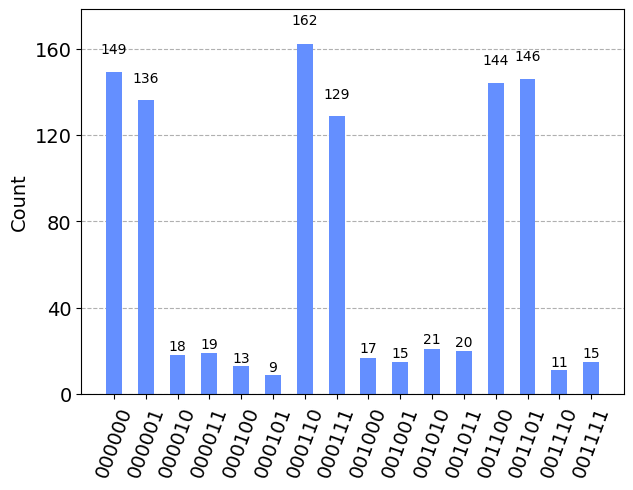

In [94]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
job = qasm_simulator.run(transpiled_qc)
plot_histogram(job.result().get_counts())

In [69]:
# Simulate state vectors
sv_sim = Aer.get_backend('statevector_simulator')
transpiled_qc = transpile(qc, sv_sim)
result = sv_sim.run(transpiled_qc).result()
statevec = result.get_statevector()

simplestatevec = []
y = 0
for i in statevec:
        simplestatevec.append(statevec[y])
        y += 1
    
# print(simplestatevec)
array_to_latex(statevec,  prefix="|\\psi\\rangle =",max_size=128)

/tmp/ipykernel_6883/2148363273.py:9: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i in statevec:


<IPython.core.display.Latex object>